<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse image reconstruction with GPax


*Prepared by Maxim Ziatdinov (May 2023)*

This notebook shows a simple example of how GPax can be utilized for sparse image reconstruction.

Install GPax:

In [1]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 13.1 MB/s eta 0:00:00


Imports:

In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

Download sparse image data. This is a scanning probe microsocpy image obtained via a sparse spiral scanning. See [this paper](https://doi.org/10.1002/smll.202002878) for more details.

In [3]:
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'

Visualize data:

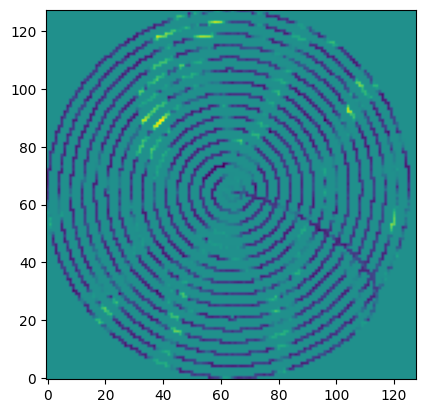

In [12]:
imgdata = np.load('spiral_scans_2d.npy')
plt.imshow(imgdata, origin='lower');

Normalize and assign zeros to regions with missing data values:

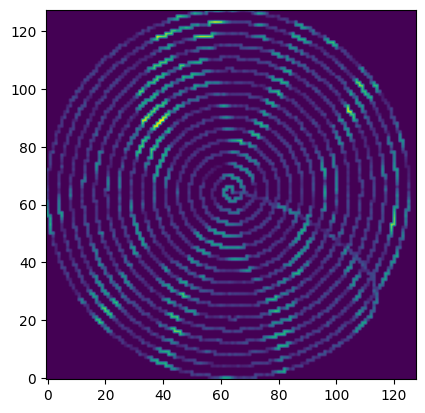

In [13]:
sparse_img = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
sparse_img[sparse_img == sparse_img[1, 1]] = 0 # Take value at [1, 1] as missing data value
plt.imshow(sparse_img, origin='lower');

Next, we prepare training inputs/targets for GP. Note that the missing data values must be represented by zeros. If you have actual data with elements whose values are zero, you will need to re-normalize it accordingly. Otherwise, those elements will be interpreted as mising values.

In [6]:
X_train, y_train, X_full = gpax.utils.preprocess_sparse_image(sparse_img)

Initilaize and train a variational inference GP model:

In [24]:
key1, key2 = gpax.utils.get_keys()

gp_model = gpax.viGP(input_dim=2, kernel='Matern', guide='delta')
gp_model.fit(key1, X_train, y_train, num_steps=250, step_size=0.05)

100%|██████████| 250/250 [00:12<00:00, 19.52it/s, init loss: 5613.0029, avg. loss [229-240]: -4457.4429]



Inferred GP kernel parameters
k_length         [4.2304    3.2705998]
k_scale          0.051999997
noise            0.0019999999


Use the trained to reconstruct the entire image (i.e., predict pixel values for a full set of pixel indices):

In [25]:
y_pred, y_var = gp_model.predict(key2, X_full, noiseless=True)

Plot the results:

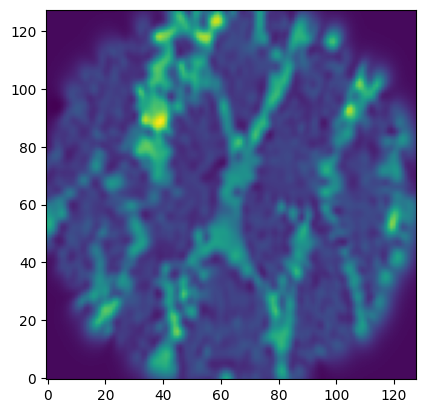

In [26]:
y_pred = y_pred.reshape(128, 128) # (height, width) of the original image
plt.imshow(y_pred, origin='lower')